# 通过构建区块链来学习区块链

最快的学习区块链工作原理的方法就是亲手构建一个
你之所以来到这里，是因为像我一样，对加密货币的兴起感到兴奋。你想了解区块链的工作原理——它们背后的基础技术。

但理解区块链并不容易——至少对我来说是这样。我费力地观看了密集的视频，跟随了不够详尽的教程，并且因为缺乏例子而倍感挫败。

我喜欢边做边学。这迫使我在代码层面上处理主题，这让知识更容易被吸收。如果你也这样做，在本指南结束时，你将拥有一个功能性的区块链，并且对它们的工作原理有一个坚实的理解。

在你开始之前…
记住，区块链是一个不可变的、顺序排列的记录链，称为区块。它们可以包含交易、文件或任何你喜欢的数据。但重要的是，它们通过哈希值连接在一起。

如果你不确定哈希是什么，这里有一个解释。

这个指南面向谁？你应该能够舒适地阅读和编写一些基本的Python代码，以及对HTTP请求的工作原理有所了解，因为我们将通过HTTP与我们的区块链进行交流。

我需要什么？确保安装了Python
3.6+（以及pip）。你还需要安装Flask和精彩的Requests库：

``` bash
pip install Flask==0.12.2 requests==2.18.4
```

哦，你还需要一个HTTP客户端，比如Postman或cURL。但任何工具都可以。

最终代码在哪里？源代码可以在这里找到。

## 第1步：构建一个区块链

打开你最喜欢的文本编辑器或IDE，个人来说我❤️
PyCharm。创建一个新文件，命名为blockchain.py。我们将只使用一个文件，但如果你迷路了，你可以随时参考源代码。

### 表示一个区块链

我们将创建一个Blockchain类，其构造函数创建一个初始的空列表（用于存储我们的区块链），以及另一个用于存储交易的列表。这是我们类的蓝图：

``` python
class Blockchain(object):
    def __init__(self):
        self.chain = []
        self.current_transactions = []
        
    def new_block(self):
        # 创建一个新的区块并将其添加到链上
        pass
    
    def new_transaction(self):
        # 将新交易添加到交易列表中
        pass
    
    @staticmethod
    def hash(block):
        # 哈希一个区块
        pass

    @property
    def last_block(self):
        # 返回链中的最后一个区块
        pass
```

(我们的Blockchain类的蓝图)

我们的Blockchain类负责管理链。它将存储交易并拥有一些辅助方法，用于将新区块添加到链上。让我们开始填充一些方法。

### 一个区块长什么样？

每个区块都有一个索引、一个时间戳（Unix时间）、一个交易列表、一个证明（稍后会详细介绍），以及前一个区块的哈希值。

这是一个单个区块的示例：

``` python
block = {
    'index': 1,
    'timestamp': 1506057125.900785,
    'transactions': [
        {
            'sender': "8527147fe1f5426f9dd545de4b27ee00",
            'recipient': "a77f5cdfa2934df3954a5c7c7da5df1f",
            'amount': 5,
        }
    ],
    'proof': 324984774000,
    'previous_hash': "2cf24dba5fb0a30e26e83b2ac5b9e29e1b161e5c1fa7425e73043362938b9824"
}
```

(我们区块链中的一个区块示例)

至此，链的概念应该很明

显了——每个新区块都包含了前一个区块的哈希值。这非常关键，因为这是区块链不可篡改性的来源：如果攻击者破坏了链中较早的一个区块，那么所有后续区块都将包含错误的哈希值。

这是否有意义？如果没有，花些时间让它沉淀下来——这是区块链背后的核心思想。

### 向区块添加交易

我们需要一种向区块添加交易的方法。我们的new_transaction()方法负责这一点，而且非常直接：

``` python
class Blockchain(object):
    ...
    
    def new_transaction(self, sender, recipient, amount):
        """
        创建一个新的交易，以进入下一个被挖掘的区块
        :param sender: <str> 发送者的地址
        :param recipient: <str> 接收者的地址
        :param amount: <int> 数量
        :return: <int> 将包含此交易的区块的索引
        """

        self.current_transactions.append({
            'sender': sender,
            'recipient': recipient,
            'amount': amount,
        })

        return self.last_block['index'] + 1
```

在new_transaction()向列表添加交易后，它返回将添加该交易的区块的索引——即下一个要被挖掘的区块。稍后，这将对提交交易的用户非常有用。

当然，这是您提供的内容的Markdown格式和中文翻译：

------------------------------------------------------------------------

### 创建新区块

当我们的区块链实例化时，我们需要用一个创世区块（没有前任的区块）来种子化它。我们还需要为我们的创世区块添加一个“证明”，这是挖矿（或工作量证明）的结果。稍后我们将更多地讨论挖矿。

除了在我们的构造函数中创建创世区块，我们还将充实`new_block()`、`new_transaction()`和`hash()`方法：

``` python
import hashlib
import json
from time import time

class Blockchain(object):
    def __init__(self):
        self.current_transactions = []
        self.chain = []

        # 创建创世区块
        self.new_block(previous_hash=1, proof=100)

    def new_block(self, proof, previous_hash=None):
        """
        在区块链中创建一个新的区块
        :param proof: <int> 工作量证明算法给出的证明
        :param previous_hash: (可选) <str> 前一个区块的哈希
        :return: <dict> 新区块
        """

        block = {
            'index': len(self.chain) + 1,
            'timestamp': time(),
            'transactions': self.current_transactions,
            'proof': proof,
            'previous_hash': previous_hash or self.hash(self.chain[-1]),
        }

        # 重置当前交易列表
        self.current_transactions = []

        self.chain.append(block)
        return block

    def new_transaction(self, sender, recipient, amount):
        """
        创建一个新的交易，进入下一个被挖掘的区块
        :param sender: <str> 发送者地址
        :param recipient: <str> 接收者地址
        :param amount: <int> 金额
        :return: <int> 将持有此交易的区块的索引
        """
        self.current_transactions.append({
            'sender': sender,
            'recipient': recipient,
            'amount': amount,
        })

        return self.last_block['index'] + 1

    @property
    def last_block(self):
        return self.chain[-1]

    @staticmethod
    def hash(block):
        """
        创建一个区块的SHA-256哈希
        :param block: <dict> 区块
        :return: <str>
        """

        # 我们必须确保字典是有序的，否则我们会得到不一致的哈希
        block_string = json.dumps(block, sort_keys=True).encode()
        return hashlib.sha256(block_string).hexdigest()
```

以上应该是直截了当的——我添加了一些注释和文档字符串来帮助保持清晰。我们几乎完成了对区块链的表示。但此时，你一定想知道新区块是如何被创建、锻造或挖掘的。

### 理解工作量证明

工作量证明算法（PoW）是在区块链上创建或挖掘新区块的方式。PoW的目标是发现一个解决问题的数字。这个数字必须难以找到，但对网络上的任何人来说都容易验证——从计算上讲。这是工作量证明背后的核心思想。

我们来看一个非常简单的例子，帮助理解这一点。

我们决定某个整数x乘以另一个y的哈希值必须以0结尾。所以，hash(x \* y) =
ac23dc…0。为了简化这个例子，我们固定x = 5。用Python实现这个：

``` python
from hashlib import sha256
x = 5
y = 0  # 我们还不知道y应该是什么...
while sha256(f'{x*y}'.encode()).hexdigest()[-1] != "0":
    y += 1
print(f'解决方案是 y = {y}')
```

这里的解决方案是y = 21。因为产生的哈希值以0结尾：

hash(5 \* 21) = 1253e9373e…5e3600155e860

在比特币中，工作量证明算法被称为Hashcash。它与我们上面的基本示例并没有太大不同。它是矿工们竞相解

决的算法，以创建一个新的区块。一般来说，难度是由在字符串中搜索的字符数量决定的。然后，矿工们通过接收一个硬币——在交易中——来获得他们的解决方案的奖励。

网络能够轻松验证他们的解决方案。

### 实现基本的工作量证明

让我们为我们的区块链实现一个类似的算法。我们的规则将类似于上面的示例：

找到一个数字p，当与前一个区块的解决方案一起哈希时，产生一个带有4个前导0的哈希。

``` python
import hashlib
import json

from time import time
from uuid import uuid4

class Blockchain(object):
    ...
        
    def proof_of_work(self, last_proof):
        """
        简单的工作量证明算法：
         - 找到一个数字p'，使得hash(pp')包含前导4个零，其中p是前一个p'
         - p是前一个证明，p'是新的证明
        :param last_proof: <int>
        :return: <int>
        """

        proof = 0
        while self.valid_proof(last_proof, proof) is False:
            proof += 1

        return proof

    @staticmethod
    def valid_proof(last_proof, proof):
        """
        验证证明：hash(last_proof, proof)是否包含4个前导零？
        :param last_proof: <int> 前一个证明
        :param proof: <int> 当前证明
        :return: <bool> 如果正确，则为True，否则为False。
        """

        guess = f'{last_proof}{proof}'.encode()
        guess_hash = hashlib.sha256(guess).hexdigest()
        return guess_hash[:4] == "0000"
```

要调整算法的难度，我们可以修改前导零的数量。但4个已经足够。你会发现，增加一个前导零对找到解决方案所需的时间产生了巨大的影响。

我们的类几乎完成了，我们准备好开始使用HTTP请求与它进行交互。

## 第2步：我们的区块链作为API

我们将使用Python
Flask框架。它是一个微框架，它使得将端点映射到Python函数变得容易。这允许我们使用HTTP请求通过网络与我们的区块链进行交流。

我们将创建三个方法：

-   `/transactions/new` 创建一个新的交易到一个区块
-   `/mine` 告诉我们的服务器挖掘一个新的区块。
-   `/chain` 返回完整的区块链

### 设置Flask

我们的“服务器”将形成我们区块链网络中的一个单独节点。让我们创建一些样板代码：

``` python
import hashlib
import json
from textwrap import dedent
from time import time
from uuid import uuid4

from flask import Flask

class Blockchain(object):
    ...

# 实例化我们的节点
app = Flask(__name__)

# 为这个节点生成一个全球唯一的地址
node_identifier = str(uuid4()).replace('-', '')

# 实例化区块链
blockchain = Blockchain()

@app.route('/mine', methods=['GET'])
def mine():
    return "We'll mine a new Block"
  
@app.route('/transactions/new', methods=['POST'])
def new_transaction():
    return "We'll add a new transaction"

@app.route('/chain', methods=['GET'])
def full_chain():
    response = {
        'chain': blockchain.chain,
        'length': len(blockchain.chain),
    }
    return jsonify(response), 200

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)
```

以上我们添加的内容的简要说明：

-   第15行：实例化我们的节点。阅读更多关于Flask的信息[这里](https://flask.palletsprojects.com/)。
-   第18行：为我们的节点创建一个随机名称。
-   第21行：实例化我们的Blockchain类。
-   第24-26行：创建`/mine`端点，这是一个GET请求。
-   第28-30行：创建`/transactions/new`端点，这是一个POST请求，因为我们将向其发送数据。
-   第32-38行：创建`/chain`端点，返回完整的区块链。
-   第40-41行：在端口5000上运行服务器。

### 交易端点

这是向服务器发送的交易请求的样子：

``` json
{
 "sender": "我的地址",
 "recipient": "别人的地址",
 "amount": 5
}
```

由于我们已经有了向区块添加交易的类方法，剩下的就简单了。让我们编写添加交易的函数：

``` python
import hashlib
import json
from textwrap import dedent
from time import time
from uuid import uuid4

from flask import Flask, jsonify, request

...

@app.route('/transactions/new', methods=['POST'])
def new_transaction():
    values = request.get_json()

    # 检查POST数据中是否包含所需字段
    required = ['sender', 'recipient', 'amount']
    if not all(k in values for k in required):
        return '缺少值', 400

    # 创建新交易
    index = blockchain.new_transaction(values['sender'], values['recipient'], values['amount'])

    response = {'message': f'交易将被添加到区块 {index}'}
    return jsonify(response), 201
```

(创建交易的方法)

### 挖矿端点

我们的挖矿端点是魔法发生的地方，而且很简单。它需要做三件事：

1.  计算工作量证明
2.  通过添加交易奖励矿工（我们）1个币
3.  通过将其添加到链中来锻造新区块

``` python
import hashlib
import json

from time import time
from uuid import uuid4

from flask import Flask, jsonify, request

...

@app.route('/mine', methods=['GET'])
def mine():
    # 我们运行工作量证明算法以获得下一个证明...
    last_block = blockchain.last_block
    last_proof = last_block['proof']
    proof = blockchain.proof_of_work(last_proof)

    # 我们必须为找到证明而获得奖励。
    # 发送者是“0”，表示这个节点挖掘了一个新币。
    blockchain.new_transaction(
        sender="0",
        recipient=node_identifier,
        amount=1,
    )

    # 通过将其添加到链中来锻造新区块
    previous_hash = blockchain.hash(last_block)
    block = blockchain.new_block(proof, previous_hash)

    response = {
        'message': "新区块已锻造",
        'index': block['index'],
        'transactions': block['transactions'],
        'proof': block['proof'],
        'previous_hash': block['previous_hash'],
    }
    return jsonify(response), 200
```

请注意，挖掘的区块的接收者是我们节点的地址。我们在这里所做的大部分工作只是与我们的区块链类的方法进行交互。到目前为止，我们已经完成了，可以开始与我们的区块链进行交互。

## 第三部: 与我们的区块链进行交互

您可以使用普通的cURL或Postman通过网络与我们的API进行交互。

启动服务器：

``` bash
$ python blockchain.py
* 正在 http://127.0.0.1:5000/ 上运行 (按 CTRL+C 退出)
```

让我们尝试通过向 http://localhost:5000/mine 发送 GET
请求来挖掘一个区块： 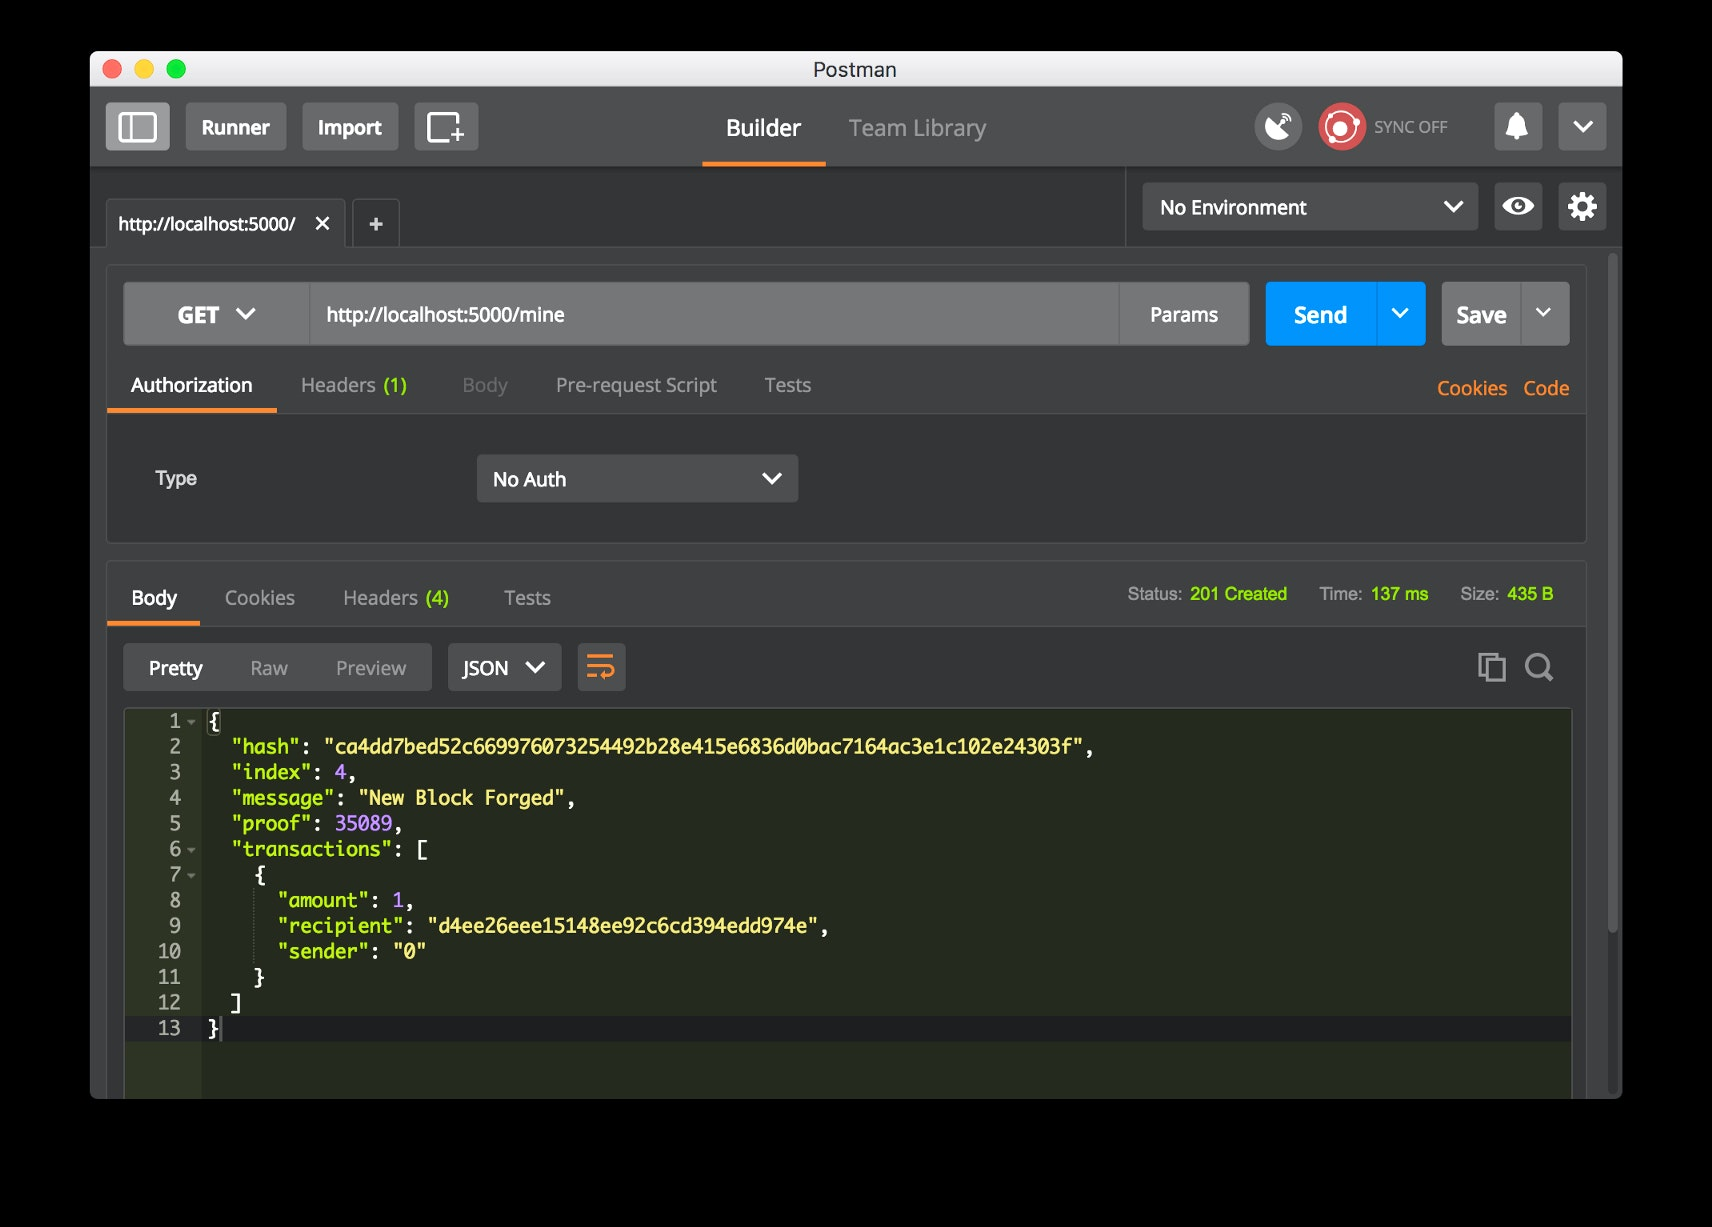(使用Postman发送GET请求的图片)

让我们通过向 http://localhost:5000/transactions/new 发送 POST
请求并带有包含我们交易结构的正文来创建一个新交易： 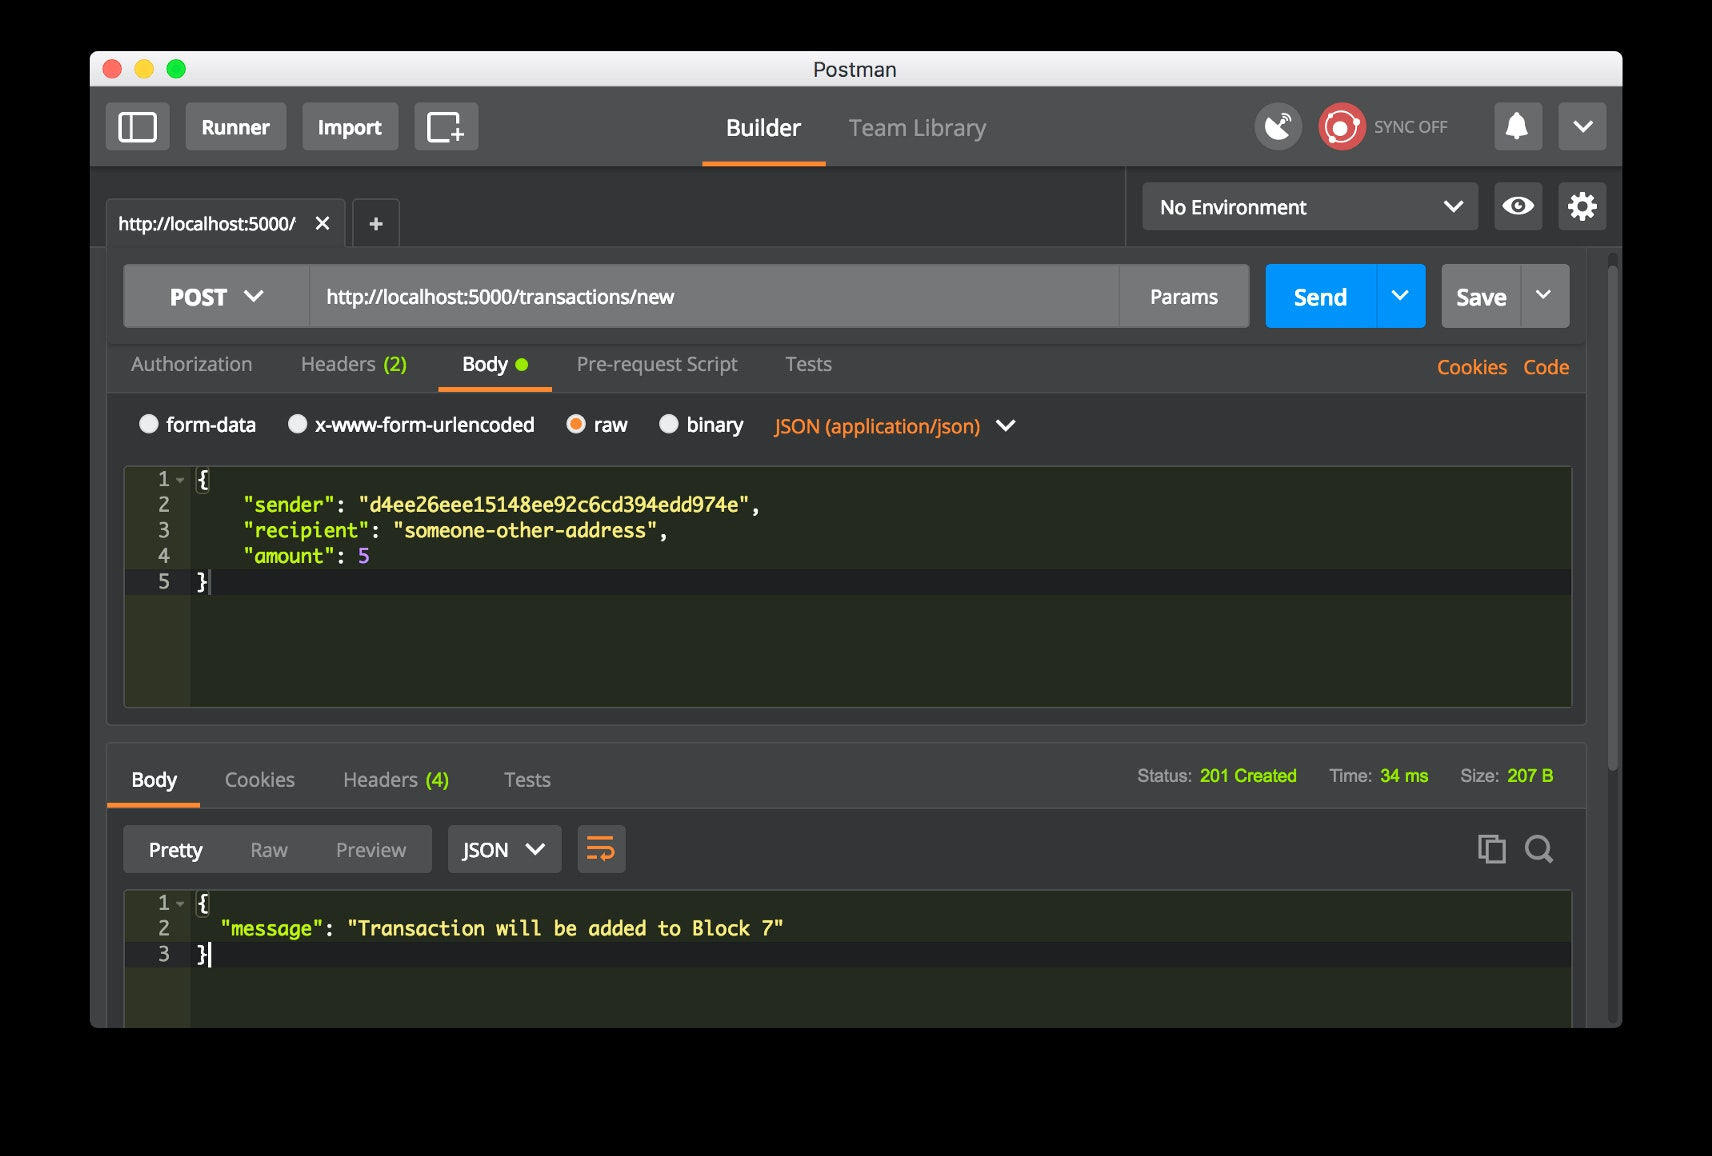(使用Postman发送POST请求的图片)

如果您不使用Postman，那么您可以使用cURL发出等效请求：

``` bash
$ curl -X POST -H "Content-Type: application/json" -d '{
 "sender": "d4ee26eee15148ee92c6cd394edd974e",
 "recipient": "某个其他地址",
 "amount": 5
}' "http://localhost:5000/transactions/new"
```

我重启了我的服务器，并挖掘了两个区块，总共有3个。让我们通过请求
http://localhost:5000/chain 来检查完整的链：

``` json
{
  "chain": [
    {
      "index": 1,
      "previous_hash": 1,
      "

proof": 100,
      "timestamp": 1506280650.770839,
      "transactions": []
    },
    {
      "index": 2,
      "previous_hash": "c099bc...bfb7",
      "proof": 35293,
      "timestamp": 1506280664.717925,
      "transactions": [
        {
          "amount": 1,
          "recipient": "8bbcb347e0634905b0cac7955bae152b",
          "sender": "0"
        }
      ]
    },
    {
      "index": 3,
      "previous_hash": "eff91a...10f2",
      "proof": 35089,
      "timestamp": 1506280666.1086972,
      "transactions": [
        {
          "amount": 1,
          "recipient": "8bbcb347e0634905b0cac7955bae152b",
          "sender": "0"
        }
      ]
    }
  ],
  "length": 3
}
```

## 第4步：共识

这非常酷。我们有了一个基本的区块链，它接受交易并允许我们挖掘新区块。但区块链的要点是它们应该是去中心化的。如果它们是去中心化的，我们如何确保它们都反映相同的链条呢？这就是所谓的共识问题，如果我们的网络中想要不止一个节点，我们就必须实现一个共识算法。

### 注册新节点

在我们实现共识算法之前，我们需要一种方法让一个节点了解网络上的邻近节点。我们网络上的每个节点都应该保持一个其他节点的注册表。因此，我们需要一些更多的端点：

-   `/nodes/register` 用于接受以URL形式的新节点列表。
-   `/nodes/resolve`
    用于实现我们的共识算法，解决任何冲突——以确保节点拥有正确的链。

我们需要修改我们的区块链构造函数，并提供一个注册节点的方法：

``` python
...
from urllib.parse import urlparse
...

class Blockchain(object):
    def __init__(self):
        ...
        self.nodes = set()
        ...

    def register_node(self, address):
        """
        将新节点添加到节点列表中
        :param address: <str> 节点地址。例如 'http://192.168.0.5:5000'
        :return: None
        """

        parsed_url = urlparse(address)
        self.nodes.add(parsed_url.netloc)
```

(向我们的网络添加邻近节点的方法)

请注意，我们使用了一个 `set()`
来保存节点列表。这是确保添加新节点是幂等的一种廉价方式——无论我们添加特定节点多少次，它都只会出现一次。

### 实现共识算法

如前所述，当一个节点与另一个节点有不同的链时，就会发生冲突。为了解决这个问题，我们将制定一个规则，即最长的有效链是权威的。换句话说，网络上的最长链是事实上的链。使用这个算法，我们在网络中的节点之间达成共识。

``` python
...
import requests

class Blockchain(object)
    ...
    
    def valid_chain(self, chain):
        """
        确定给定的区块链是否有效
        :param chain: <list> 一个区块链
        :return: <bool> 如果有效则为True，否则为False
        """

        last_block = chain[0]
        current_index = 1

        while current_index < len(chain):
            block = chain[current_index]
            print(f'{last_block}')
            print(f'{block}')
            print("\n-----------\n")
            # 检查区块的哈希是否正确
            if block['previous_hash'] != self.hash(last_block):
                return False

            # 检查工作量证明是否正确
            if not self.valid_proof(last_block['proof'], block['proof']):
                return False

            last_block = block
            current_index += 1

        return True

    def resolve_conflicts(self):
        """
        这是我们的共识算法，它通过用网络中最长的链替换我们的链来解决冲突。
        :return: <bool> 如果我们的链被替换则为True，否则为False
        """

        neighbours = self.nodes
        new_chain = None

        # 我们只寻找比我们的链更长的链
        max_length = len(self.chain)

        # 从我们网络中的所有节点获取并验证链
        for node in neighbours:
            response = requests.get(f'http://{node}/chain')

            if response.status_code == 200:
                length = response.json()['length']
                chain = response.json()['chain']

                # 检查链的长度是否更长且链是否有效
                if length > max_length and self.valid_chain(chain):
                    max_length = length
                    new_chain = chain

        # 如果我们发现了一个新的、有效的、比我们的更长的链，就替换我们的链
        if new_chain:
            self.chain = new_chain


            return True
 




 
        return False
```

第一个方法 `valid_chain()`
负责检查一个链是否有效，通过遍历每个区块并验证哈希和工作量证明。

`resolve_conflicts()`
是一个方法，它遍历我们所有的邻近节点，下载它们的链并使用上述方法进行验证。如果找到了一个有效的链，且其长度大于我们的链，我们就替换我们的链。

让我们将这两个端点注册到我们的API中，一个用于添加邻近节点，另一个用于解决冲突：

``` python
@app.route('/nodes/register', methods=['POST'])
def register_nodes():
    values = request.get_json()

    nodes = values.get('nodes')
    if nodes is None:
        return "Error: Please supply a valid list of nodes", 400

    for node in nodes:
        blockchain.register_node(node)

    response = {
        'message': '新节点已添加',
        'total_nodes': list(blockchain.nodes),
    }
    return jsonify(response), 201


@app.route('/nodes/resolve', methods=['GET'])
def consensus():
    replaced = blockchain.resolve_conflicts()

    if replaced:
        response = {
            'message': '我们的链已被替换',
            'new_chain': blockchain.chain
        }
    else:
        response = {
            'message': '我们的链是权威的',
            'chain': blockchain.chain
        }

    return jsonify(response), 200
```

此时，您可以使用不同的机器，并在您的网络上启动不同的节点。或者在同一台机器上使用不同的端口启动进程。我在我的机器上启动了另一个节点，在不同的端口上，并将其注册到我的当前节点。因此，我有两个节点：http://localhost:5000
和 http://localhost:5001。 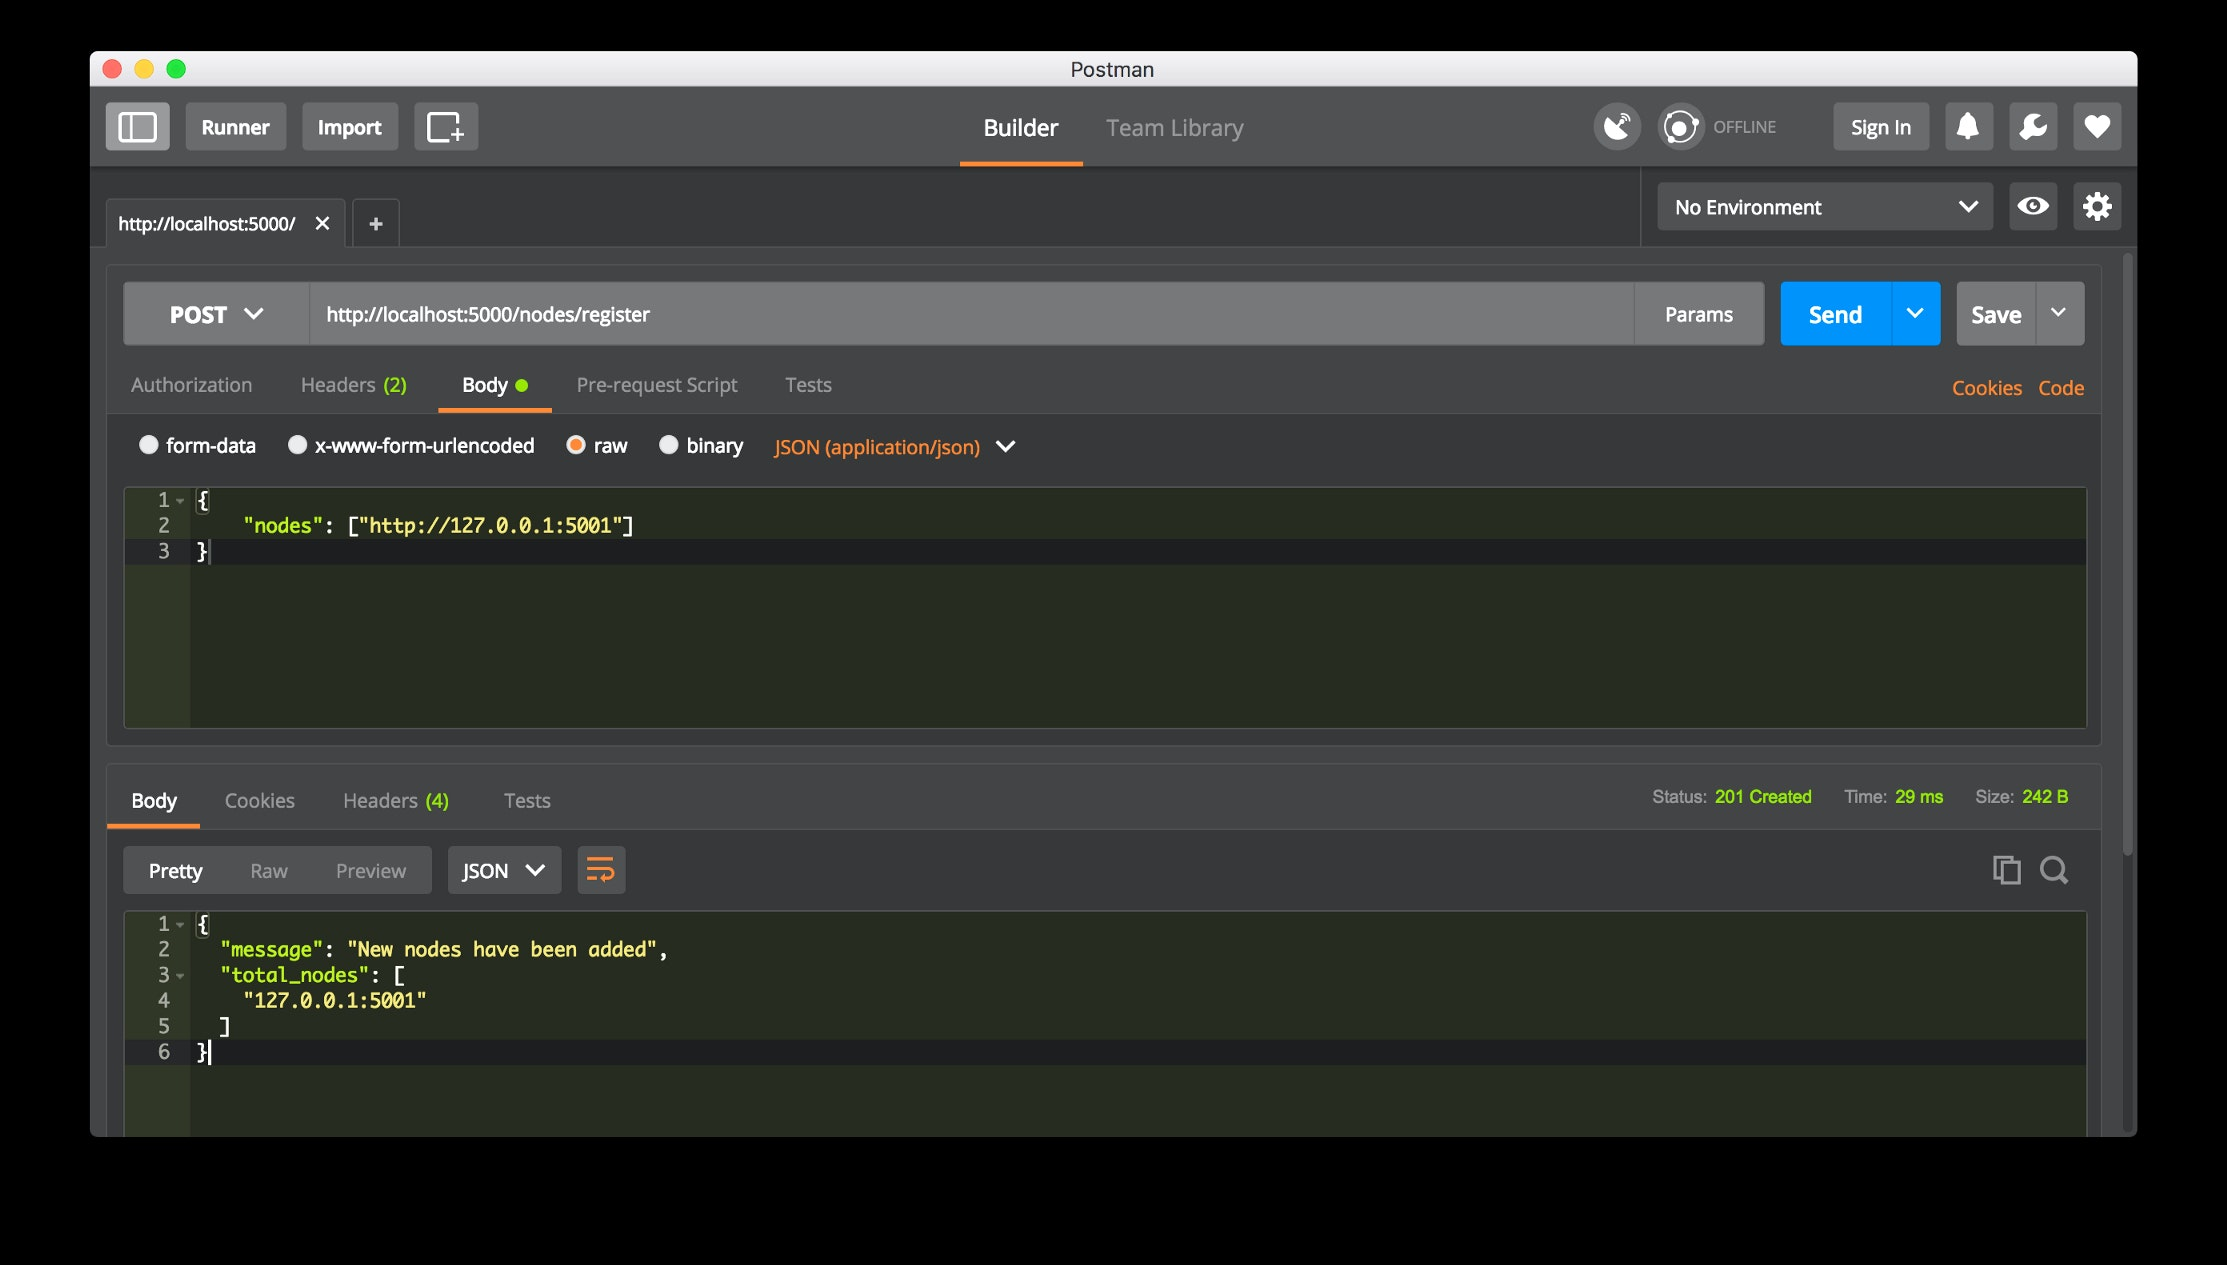
(注册新节点)

然后，我在节点2上挖掘了一些新区块，以确保链更长。之后，我在节点1上调用了
GET /nodes/resolve，链条被共识算法替换了：

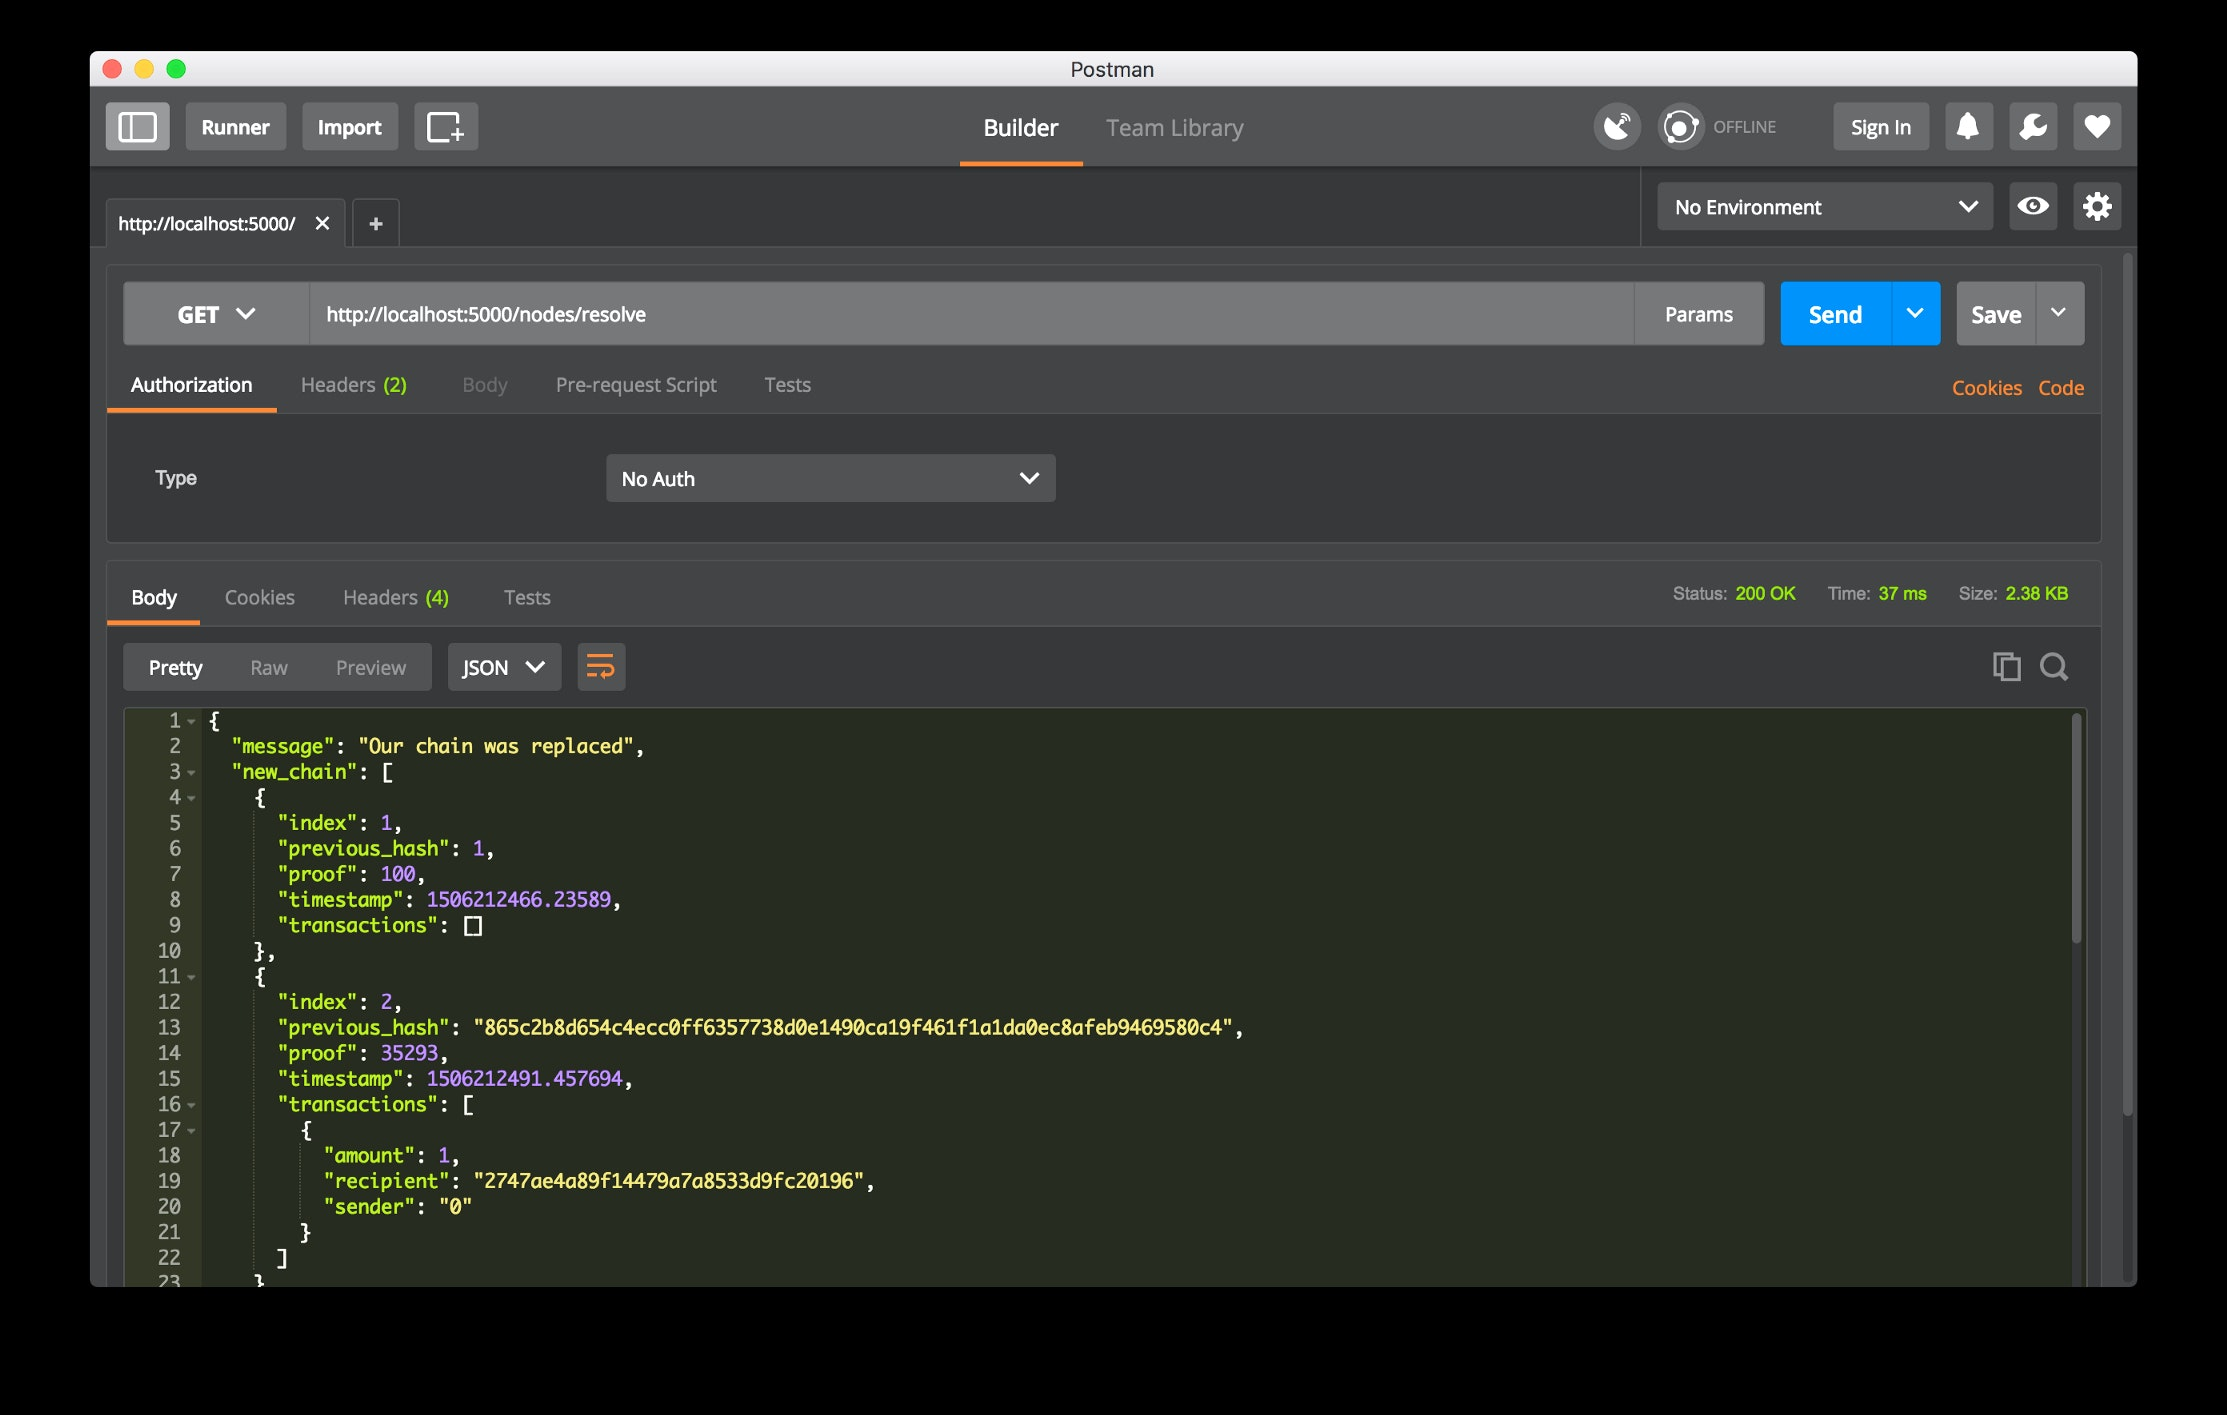 (共识算法工作中)

就这样完成了… 召集一些朋友来帮助测试你的区块链。

我希望这能激发你创造新事物的灵感。我对加密货币感到兴奋，因为我相信区块链将迅速改变我们对经济、政府和记录保存的看法。

## 第5步：执行代码

``` bash
$ pip install --upgrade -r requirements.txt
$ python3 blockchain.py --port 5002 #启动节点
```